In [66]:
# Labirinto modificado

from typing import Iterable, Tuple, Dict, List
from collections import deque
from time import perf_counter
import matplotlib.pyplot as plt
from random import randint
import tracemalloc as tm
import gc

maze = [
    list("S...#....#......"),
    list(".###.#.##.#.####"),
    list("...#.#....#....."),
    list("##.#.######.###."),
    list("...#........#..."),
    list(".#####.######.#."),
    list(".....#....#....."),
    list("###.#.##.#.#.###"),
    list("...#.#..#.#.#..."),
    list(".#.#.##.#.#.###."),
    list(".#...#....#....."),
    list(".#####.########."),
    list(".....#.........."),
    list("###.#.#########."),
    list(".....#........G.")
]

In [67]:
# Encontrar caractere S e G (Start e Goal)
ROWS, COLS = len(maze), len(maze[0])

def find_char(grid, ch: str) -> Tuple[int, int]:
    """Encontra a primeira ocorrência do caractere `ch` no grid. Retorna (linha, coluna). Levanta ValueError se não encontrado."""
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            if grid[r][c] == ch:
                return (r, c)
    raise ValueError(f"Caractere {ch} não encontrado.")

start = find_char(maze, "S")
goal  = find_char(maze, "G")

start, goal

((0, 0), (14, 14))

In [68]:
# Obter todos os estados

def neighbors(pos: Tuple[int,int], grid) -> Iterable[Tuple[int,int]]:
    """Retorna todos os vizinhos válidos (cima, baixo, esquerda, direita e diagonais) dentro dos limites e não bloqueados por parede."""
    r, c = pos
    for dr, dc in [(-1,0), (1,0), (0,-1), (0,1), (-1, -1), (1, -1), (-1, 1), (1, 1)]:  # cima, baixo, esq, dir e diagonais
        nr, nc = r + dr, c + dc
        if 0 <= nr < len(grid) and 0 <= nc < len(grid[0]):
            if grid[nr][nc] != '#':  # não atravessa parede
                yield (nr, nc)

list(neighbors(start, maze))

[(1, 0), (0, 1)]

In [69]:
# Reconstruir caminho no grid

def reconstruct_path_grid(parent: Dict[Tuple[int,int], Tuple[int,int]], start, goal) -> List[Tuple[int,int]]:
    """Reconstrói o caminho do start ao goal usando o mapa de pais de uma execução BFS/DFS. Retorna lista de (linha, coluna) do start ao goal, ou [] se não houver caminho."""
    if goal not in parent and goal != start:
        return []
    path = [goal]
    cur = goal
    while cur != start:
        cur = parent[cur]
        path.append(cur)
    path.reverse()
    return path

In [70]:
# BFS no grid

def bfs_grid(grid, start, goal):
    """Executa busca em largura no grid do start ao goal. Retorna (found: bool, path: lista de (linha,col)). Path vazio se não existir rota."""
    q = deque([start])
    visited = {start}
    parent = {}

    while q:
        u = q.popleft()
        if u == goal:
            return True, reconstruct_path_grid(parent, start, goal)

        for v in neighbors(u, grid):
            if v not in visited:
                visited.add(v)
                parent[v] = u
                q.append(v)

    return False, []

In [71]:
# DFS no grid
def dfs_grid(grid, start, goal):
    """Executa busca em profundidade no grid do start ao goal. Retorna (found: bool, path: lista de (linha,col)). Path vazio se não existir rota."""
    stack = [start]
    visited = {start}
    parent = {}

    while stack:
        u = stack.pop()
        if u == goal:
            return True, reconstruct_path_grid(parent, start, goal)

        # ordem reversa para deixar o comportamento mais reprodutível
        for v in reversed(list(neighbors(u, grid))):
            if v not in visited:
                visited.add(v)
                parent[v] = u
                stack.append(v)

    return False, []

In [72]:
# Aqui foi feito para testar o tempo de execução das funções BFS e DFS e gerar o primeiro gráfico
bfs_time_start = perf_counter()
found_bfs, path_bfs = bfs_grid(maze, start, goal)
bfs_time_end = perf_counter()

bfs_time = bfs_time_end - bfs_time_start

dfs_time_start = perf_counter()
found_dfs, path_dfs = dfs_grid(maze, start, goal)
dfs_time_end = perf_counter()

dfs_time = dfs_time_end - dfs_time_start

print(bfs_time, dfs_time, 'segundos.')

0.0002658999874256551 0.000225800002226606 segundos.


Text(0, 0.5, 'Times')

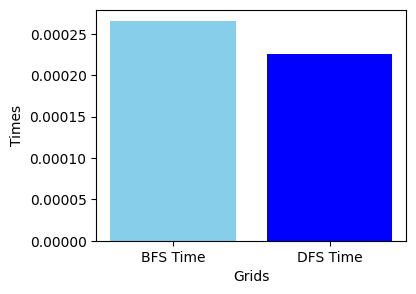

In [73]:
# Melhor grid executado pela última vez

plt.figure(figsize=(4, 3))
plt.bar(['BFS Time', 'DFS Time'], [bfs_time, dfs_time], color=['skyblue', 'blue'])
plt.xlabel('Grids')
plt.ylabel('Times')

In [74]:
# Versão 2.0
def get_bfs_time(maze):
    """Mede e retorna o tempo de execução do BFS (em segundos) para o labirinto dado. Usado para gráficos de comparação de desempenho."""
    bfs_time_start = perf_counter()
    bfs_grid(maze, start, goal)
    bfs_time_end = perf_counter()

    bfs_time = bfs_time_end - bfs_time_start

    return bfs_time

def get_dfs_time(maze):
    """Mede e retorna o tempo de execução do DFS (em segundos) para o labirinto dado. Usado para gráficos de comparação de desempenho."""
    dfs_time_start = perf_counter()
    dfs_grid(maze, start, goal)
    dfs_time_end = perf_counter()

    dfs_time = dfs_time_end - dfs_time_start

    return dfs_time

def get_bfs_memory(maze):
    """Mede e retorna o pico de uso de memória do BFS (em KB) para o labirinto dado usando tracemalloc. Usado para gráficos de comparação de memória. Imprime o valor e retorna."""
    gc.collect()
    tm.start()
    bfs_grid(maze, start, goal)

    current, peak = tm.get_traced_memory()

    peak_kb = peak / 1024
    print(f'KB usados no BFS: {peak_kb} com o labirinto de tamanho {len(maze)}')

    tm.stop()

    return peak_kb

def get_dfs_memory(maze):
    """Mede e retorna o pico de uso de memória do DFS (em KB) para o labirinto dado usando tracemalloc. Usado para gráficos de comparação de memória. Imprime o valor e retorna."""
    gc.collect()
    tm.start()
    dfs_grid(maze, start, goal)

    current, peak = tm.get_traced_memory()

    peak_kb = peak / 1024
    print(f'KB usados no DFS: {peak_kb} com o labirinto de tamanho {len(maze)}')

    tm.stop()

    return peak_kb

In [ ]:
# Aqui a lógica para gerar os gráficos de comparação de desempenho e memória
# Cada laço do bigO é uma execução da função BFS e DFS com um labirinto aleatório gerado com mais linhas para testar o desempenho com mais dados
# Depois os tempos e memórias são adicionados nas listas para fazer os gráficos
# Também é calculado a média de tempo e memória para cada função para gerar informações adicionais além dos gráficos

bfs_times = list()
dfs_times = list()

bfs_memory = list()
dfs_memory = list()

for bigO in range(5):
    for j in range(50):
        index = randint(1, len(maze)-2)
        new_list = maze[index]
        maze.insert(-2, new_list) # adiciona uma linha aleatória 
    
    bfs_times.append(get_bfs_time(maze))
    dfs_times.append(get_dfs_time(maze))

    bfs_memory.append(get_bfs_memory(maze))
    dfs_memory.append(get_dfs_memory(maze))

avg_bfs_time = sum(bfs_times) / len(bfs_times)
avg_dfs_time = sum(dfs_times) / len(dfs_times)

avg_bfs_memory = sum(bfs_memory) / len(bfs_memory)
avg_dfs_memory = sum(dfs_memory) / len(dfs_memory)

KB usados no BFS: 83.2421875 com o labirinto de tamanho 65
KB usados no DFS: 86.5703125 com o labirinto de tamanho 65
KB usados no BFS: 125.125 com o labirinto de tamanho 115
KB usados no DFS: 129.125 com o labirinto de tamanho 115
KB usados no BFS: 125.2890625 com o labirinto de tamanho 165
KB usados no DFS: 129.125 com o labirinto de tamanho 165
KB usados no BFS: 125.2890625 com o labirinto de tamanho 215
KB usados no DFS: 129.125 com o labirinto de tamanho 215
KB usados no BFS: 125.28125 com o labirinto de tamanho 265
KB usados no DFS: 133.0673828125 com o labirinto de tamanho 265


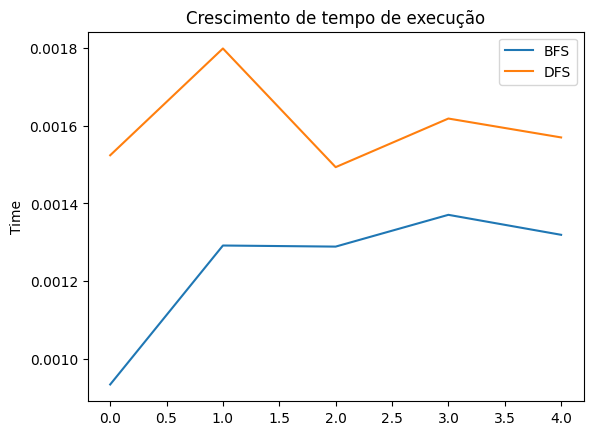

DFS teve um desempenho inferior ao BFS para encontrar o caminho do labirinto
Com a média de 0.0016010800027288496 segundos
Com a diferença média de 0.0003605400037486107 segundos.


In [76]:
# Gráficos para comparar tempo de execução BFS vs DFS
plt.plot(bfs_times)
plt.plot(dfs_times)

plt.ylabel("Time")
plt.title("Crescimento de tempo de execução")
plt.legend(["BFS", "DFS"])
plt.show()

if max(bfs_times) > max(dfs_times):
    print(f'BFS teve um desempenho inferior ao DFS para encontrar o caminho do labirinto\nCom a média de {avg_bfs_time} segundos\nCom a diferença média de {avg_bfs_time-avg_dfs_time} segundos.')
elif max(dfs_times) > max(bfs_times):
    print(f'DFS teve um desempenho inferior ao BFS para encontrar o caminho do labirinto\nCom a média de {avg_dfs_time} segundos\nCom a diferença média de {avg_dfs_time-avg_bfs_time} segundos.')

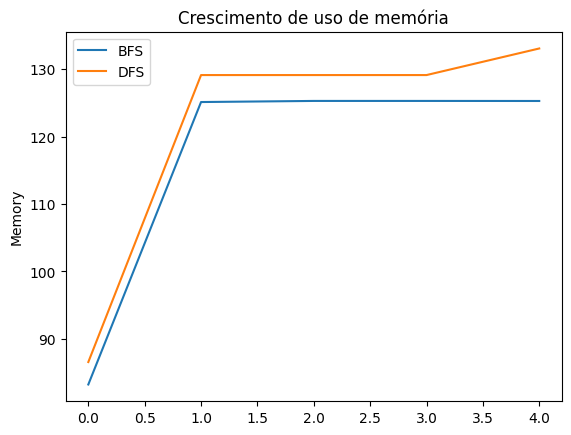

DFS teve um desempenho inferior ao BFS em uso de memória ao executar a função e encontrar os caminhos no labirinto
Com a média de 121.4 bytes
Com a diferença média de 4.56 bytes para mais.


In [79]:
# Gráfico para comparar memória usada em BFS e DFS no grid
plt.plot(bfs_memory)
plt.plot(dfs_memory)

plt.ylabel("Memory")
plt.title("Crescimento de uso de memória")
plt.legend(["BFS", "DFS"])
plt.show()

if avg_bfs_memory > avg_dfs_memory:
    print(f'BFS teve um desempenho inferior ao DFS em uso de memória ao executar a função e encontrar os caminhos no labirinto\nCom a média de {round(avg_bfs_memory, 2)} bytes\nCom a diferença média de {round(avg_bfs_memory-avg_dfs_memory, 2)} bytes para mais.')
elif avg_dfs_memory > avg_bfs_memory:
    print(f'DFS teve um desempenho inferior ao BFS em uso de memória ao executar a função e encontrar os caminhos no labirinto\nCom a média de {round(avg_dfs_memory, 2)} bytes\nCom a diferença média de {round(avg_dfs_memory-avg_bfs_memory, 2)} bytes para mais.')